<a href="https://colab.research.google.com/github/kiwihero/icecream-recommendation-system/blob/simpleRNN/icecream_LSTM_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Icecream Recomendation system using RNN

    1.Import necessary Libraries
    2.Exploratory Data Analysis(Duplicates, Missing Data)
    3.Data Clensing & Feature Engineering
    4.Data preprocessing
    5.Model Building
    6.Model Evaluation

1. Import libraries

In [2]:
#imports
import numpy as np #Mathematical Operations
import pandas as pd #Data analysis
import matplotlib.pyplot as plt 
import seaborn as sns #Visulisation
from __future__ import print_function
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer, normalize
from sklearn.model_selection import train_test_split
import keras
from keras.preprocessing import sequence #To preprocess sequence data
from keras.models import Sequential #Sequential Model
from keras.layers import Dense, Embedding,Dropout,LSTM,Flatten #Fully connected layer
from keras.layers import SimpleRNN #Model
from keras import initializers #To initialize random weights of layers
from keras.preprocessing.text import Tokenizer

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# processing data set and filtering out columns that have no information
products = pd.read_csv("/content/drive/MyDrive/Kaggle/combined/products.csv")
products = products.drop(["subhead"],1)

reviews = pd.read_csv("/content/drive/MyDrive/Kaggle/combined/reviews.csv")
reviews=reviews.drop(["ingredients","texture", "likes","taste"],axis=1)



2. Exploratory Data Analysis(Duplicates, Missing Data)

3. Data Cleansing

In [7]:
# Datasets size
print(products.shape)
print(reviews.shape)

(241, 7)
(21674, 9)


In [8]:
# Look for unique count of each feature
products.nunique()

brand             4
key             241
name            240
description     237
rating           29
rating_count    136
ingredients     240
dtype: int64

Take-away: 
1. By looking at unique count name and ingredients having one duplicate each let's see why it has a duplicate
2. Description feature having 4 duplicate records

In [9]:
# Find the duplicate in name columns
products[products['name'].duplicated()]

,brand,key,name,description,rating,rating_count,ingredients
221,breyers,49_breyers,Chocolate Chip Cookie Dough,With creamy vanilla and chunks of cookie dough...,1.2,89,"MILK, SUGAR, CORN SYRUP, CREAM, ENRICHED WHEAT..."


In [10]:
#Find the other record with same name
products[products['name'] == 'Chocolate Chip Cookie Dough']

,brand,key,name,description,rating,rating_count,ingredients
16,bj,16_bj,Chocolate Chip Cookie Dough,We knew we were onto something big when we mad...,4.6,983,"CREAM, SKIM MILK, LIQUID SUGAR (SUGAR, WATER),..."
221,breyers,49_breyers,Chocolate Chip Cookie Dough,With creamy vanilla and chunks of cookie dough...,1.2,89,"MILK, SUGAR, CORN SYRUP, CREAM, ENRICHED WHEAT..."


Take-away: Same name but different brand, so make sense to keep both

In [11]:
# Check of count of each column
products.count()

brand           241
key             241
name            241
description     237
rating          241
rating_count    241
ingredients     241
dtype: int64

In [12]:
# Look for count of nulls in products dataframe
products.isna().sum()

brand           0
key             0
name            0
description     4
rating          0
rating_count    0
ingredients     0
dtype: int64

In [13]:
# Explore the data where description is null
products[products['description'].isnull()]

,brand,key,name,description,rating,rating_count,ingredients
139,talenti,12_talenti,COCONUT CHOCOLATE COOKIE,NaN,4.3,29,"WATER, SUGAR, DESICCATED COCONUT, COCONUT OIL,..."
158,talenti,31_talenti,PACIFIC COAST PISTACHIO GELATO,NaN,4.5,201,"MILK, SUGAR, CREAM, PISTACHIOS, DEXTROSE, CARO..."
165,talenti,38_talenti,SALTED CARAMEL TRUFFLE,NaN,4.7,160,"MILK, SUGAR, SKIM MILK, CREAM, WATER, COCONUT ..."
166,talenti,39_talenti,SEA SALT CARAMEL GELATO,NaN,4.1,146,"MILK, SKIM MILK, SUGAR, CREAM, EGG YOLK AND WH..."


Take-away: As Description feature having nulls not even 2% of the dataset  so 
dropping those records won't impact.

In [14]:
# Drop records where null values in any column
products.dropna(inplace=True)

In [15]:
#Check count of each column
products.count()

brand           237
key             237
name            237
description     237
rating          237
rating_count    237
ingredients     237
dtype: int64

4.Data preprocessing

In [17]:
# Slicing the dependent & independent features
x = products['description']
y = products['key']

In [18]:
# Check for max length of words in x, y
print("Max length of Ingredients", x.apply(lambda x:len(str(x).split())).max())
print("Max length of Key", y.apply(lambda x:len(str(x).split())).max())

Max length of Ingredients 290
Max length of Key 1


In [19]:
# Lable encoding for ice cream keys
mlb = MultiLabelBinarizer()

res = pd.DataFrame(mlb.fit_transform(x),
                   columns=mlb.classes_,
                   index=x.index)

Preparing the data for training using train_test_split.
https://www.bitdegree.org/learn/train-test-split

In [20]:

## split the data 
x_train, x_test, y_train, y_test = train_test_split(res,y, test_size=0.2, random_state=42)
#train, test = train_test_split(products, test_size=0.2, random_state=42)

print("Train data shape:", len(x_train))
print("Test shape:", len(x_test))

Train data shape: 189
Test shape: 48


In [21]:
print(len(x_train))
print(len(x_test))

189
48


In [22]:
y_test.shape

(48,)

In [23]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

In [24]:
norm = np.linalg.norm(y_train)
y_train = y_train/norm

In [25]:
norm = np.linalg.norm(y_test)
y_test = y_test/norm

In [40]:
# building RNN model
max_features = 3000
rnn_hidden_dim = 100
word_embedding_dim = 30000
model_rnn = Sequential()
model_rnn.add(Embedding(max_features, word_embedding_dim))
model_rnn.add(Dropout(0.4))
model_rnn.add(LSTM(32))
model_rnn.add(Dropout(0.4))
model_rnn.add(Dense(237, activation='sigmoid'))

In [41]:
model_rnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 30000)       90000000  
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 30000)       0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                3844224   
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 237)               7821      
Total params: 93,852,045
Trainable params: 93,852,045
Non-trainable params: 0
_________________________________________________________________


In [42]:
rmsprop = keras.optimizers.RMSprop(lr = .1)

model_rnn.compile(loss='SparseCategoricalCrossentropy',
              optimizer=rmsprop,
              metrics=['accuracy'])

In [43]:
batch_size = 128
history = model_rnn.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=10,
          validation_data=(x_test, y_test))

Epoch 1/10
2/2 [==============================] - 25s 8s/step - loss: 4.3606 - accuracy: 0.0000e+00 - val_loss: 1.1206e-05 - val_accuracy: 0.0208
Epoch 2/10
2/2 [==============================] - 20s 7s/step - loss: 0.0020 - accuracy: 0.0061 - val_loss: 8.2254e-06 - val_accuracy: 0.0208
Epoch 3/10
2/2 [==============================] - 20s 7s/step - loss: 0.0010 - accuracy: 0.0061 - val_loss: 6.7949e-06 - val_accuracy: 0.0208
Epoch 4/10
2/2 [==============================] - 20s 7s/step - loss: 0.0011 - accuracy: 0.0061 - val_loss: 5.4836e-06 - val_accuracy: 0.0208
Epoch 5/10
2/2 [==============================] - 20s 7s/step - loss: 0.0010 - accuracy: 0.0061 - val_loss: 3.8147e-06 - val_accuracy: 0.0208
Epoch 6/10
2/2 [==============================] - 20s 7s/step - loss: 0.0015 - accuracy: 0.0035 - val_loss: 3.0994e-06 - val_accuracy: 0.0208
Epoch 7/10
2/2 [==============================] - 20s 7s/step - loss: 4.0444e-04 - accuracy: 0.0061 - val_loss: 2.6226e-06 - val_accuracy: 0.020

In [44]:
print(len(y_train))
print(len(y_test))

189
48


In [45]:
# variable for unique product key for ice cream brand and flavor
n_product = len(products.key.unique())
print(n_product)

237


In [47]:
## We will use Keras evaluate function to evaluate performance on the test set

score = model_rnn.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.311301275563892e-06
Test accuracy: 0.02083333395421505


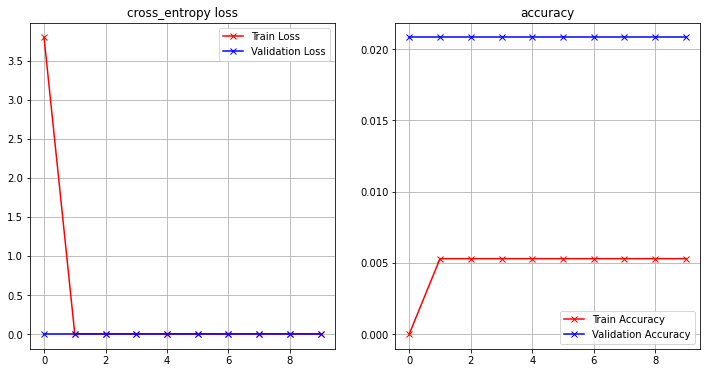

In [48]:
# Write a function to plot the train & test losses
def plot_loss_accuracy(history):
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history.history["loss"],'r-x', label="Train Loss")
    ax.plot(history.history["val_loss"],'b-x', label="Validation Loss")
    ax.legend()
    ax.set_title('cross_entropy loss')
    ax.grid(True)


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history.history["accuracy"],'r-x', label="Train Accuracy")
    ax.plot(history.history["val_accuracy"],'b-x', label="Validation Accuracy")
    ax.legend()
    ax.set_title('accuracy')
    ax.grid(True)  

# Calling the function
plot_loss_accuracy(history)